In [12]:
import os
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Dropout, 
                                     Flatten, Conv2D, GlobalAveragePooling2D,
                                     MaxPooling2D, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import save_model, load_model

In [2]:
def generate_dataset(path):
    data = {'imgpath': [], 'labels': []}
    
    folders = os.listdir(path)
    
    for folder in folders:
        folderpath = os.path.join(path, folder)
        files = os.listdir(folderpath)
        
        for file in files:
            filepath = os.path.join(folderpath, file)
            
            data['imgpath'].append(filepath)
            data['labels'].append(folder)
    
    return pd.DataFrame(data)


def dataset_splitter(dataset, train_size = 0.9, shuffle = True, random_state = 0):
    train_df, val_df = train_test_split(dataset, train_size = train_size, shuffle = shuffle, random_state = random_state)

    train_df = train_df.reset_index(drop = True)
    val_df = val_df.reset_index(drop = True)
    
    return train_df, val_df


def plot_counts(dataset):
    species_counts = dataset['labels'].value_counts()

    plt.figure(figsize=(12, 6))
    species_counts.plot(kind = 'bar', color = 'skyblue')
    plt.title("Count of Alphabets")
    plt.xlabel("Alphabets")
    plt.ylabel("Count")
    plt.xticks(rotation = 45, ha = 'right')
    plt.tight_layout()
    plt.show()


In [3]:
dataset_path = '/home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Sign-Language-Detection/DATA/asl_alphabet_train/asl_alphabet_train'

dataset = generate_dataset(dataset_path)


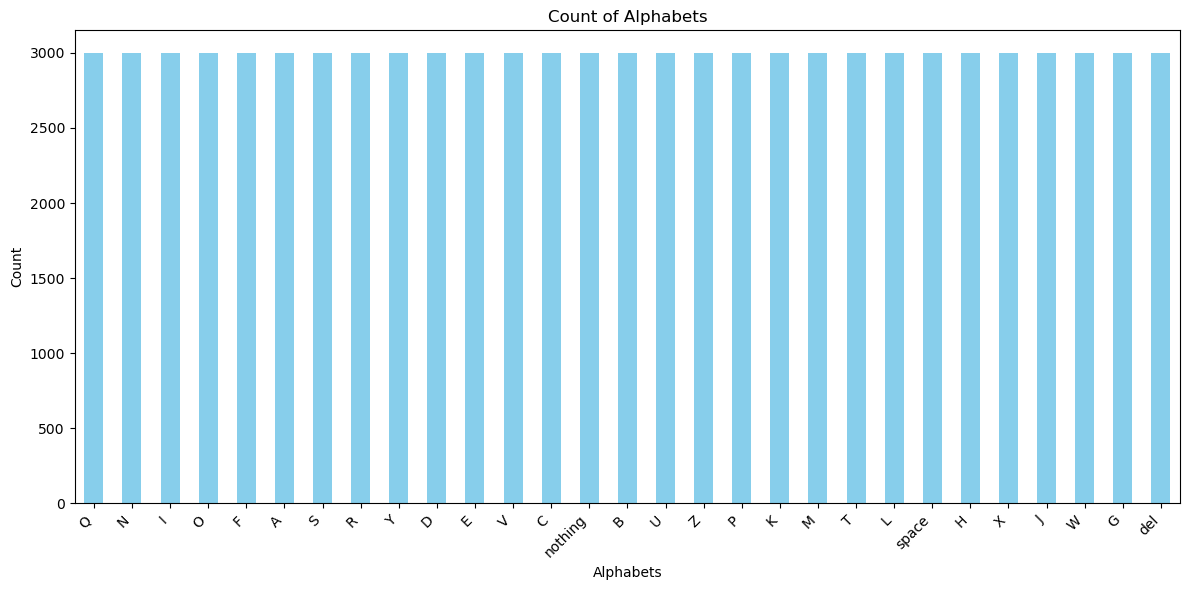

In [4]:
plot_counts(dataset)

In [5]:
train_df, val_df= dataset_splitter(dataset)

print(f'\nTraining Dataframe of shape {train_df.shape}: \n{train_df.head()}')
print(f'\nValidation Dataframe of shape {val_df.shape}: \n{val_df.head()}')


Training Dataframe of shape (78300, 2): 
                                             imgpath labels
0  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      C
1  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      H
2  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      I
3  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      B
4  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      S

Validation Dataframe of shape (8700, 2): 
                                             imgpath labels
0  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      J
1  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      A
2  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      Z
3  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      V
4  /home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Si...      B


In [6]:
%%time

BATCH_SIZE = 128
IMG_SIZE = (64, 64)

train_generator = ImageDataGenerator(1./255, 
                                     rotation_range = 10, 
                                     height_shift_range = 0.1, 
                                     width_shift_range = 0.1)

val_generator = ImageDataGenerator(1./255)

train_images = train_generator.flow_from_dataframe(train_df, x_col = 'imgpath', y_col = 'labels', 
                                                   color_mode = 'grayscale', class_mode = 'categorical',
                                                   batch_size = BATCH_SIZE, target_size = IMG_SIZE, 
                                                   shuffle = True, seed = 0)

val_images = val_generator.flow_from_dataframe(val_df, x_col = 'imgpath', y_col = 'labels', 
                                               color_mode = 'grayscale', class_mode = 'categorical', 
                                               batch_size = BATCH_SIZE, target_size = IMG_SIZE)

Found 78300 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
CPU times: user 340 ms, sys: 171 ms, total: 512 ms
Wall time: 511 ms


In [7]:
output_shape = len(set(train_images.labels))

model = Sequential([
    Input(shape = IMG_SIZE + (1,), name = 'input_layer'),
    
    Conv2D(16, (3, 3), activation = 'relu'),
    MaxPooling2D(pool_size = (3, 3)),
    
    Conv2D(32, (3, 3), activation = 'relu'),
    MaxPooling2D(pool_size = (3, 3)),
    
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(pool_size = (3, 3)),
    
    GlobalAveragePooling2D(),
    BatchNormalization(),
    
    Dense(512, activation = 'relu'),
    Dropout(0.3),
    
    Dense(512, activation = 'relu'),
    
    Dense(output_shape, activation = 'softmax', name = 'output_layer')
])

model.compile(optimizer = Adamax(learning_rate = 1e-3), 
              loss = CategoricalCrossentropy(), 
              metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 18, 18, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 29)             │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,365 (1.28 MB)

 Trainable params: 334,237 (1.28 MB)

 Non-trainable params: 128 (512.00 B)

In [8]:
%%time

model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, restore_best_weights = True)

history = model.fit(train_images, validation_data = val_images, epochs = 30, callbacks = [model_es])

/home/aditya/.local/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/30


/home/aditya/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


612/612 ━━━━━━━━━━━━━━━━━━━━ 73s 116ms/step - accuracy: 0.2748 - loss: 2.5140 - val_accuracy: 0.5218 - val_loss: 1.5286
Epoch 2/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 76s 123ms/step - accuracy: 0.6230 - loss: 1.1847 - val_accuracy: 0.6937 - val_loss: 0.9460
Epoch 3/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 75s 122ms/step - accuracy: 0.7170 - loss: 0.8726 - val_accuracy: 0.7729 - val_loss: 0.6972
Epoch 4/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 76s 123ms/step - accuracy: 0.7648 - loss: 0.7133 - val_accuracy: 0.8001 - val_loss: 0.5753
Epoch 5/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.8021 - loss: 0.5962 - val_accuracy: 0.8482 - val_loss: 0.4574
Epoch 6/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 72s 117ms/step - accuracy: 0.8272 - loss: 0.5163 - val_accuracy: 0.8733 - val_loss: 0.3821
Epoch 7/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 73s 118ms/step - accuracy: 0.8432 - loss: 0.4699 - val_accuracy: 0.8861 - val_loss: 0.3311
Epoch 8/30
612/612 ━━━━━━━━━━━━━━━━━━━━ 73s 119ms/step - accuracy: 0.8633 - loss: 0.4133 - val

In [9]:
results = model.evaluate(val_images, verbose = 0)

print("    Validation Loss: {:.5f}".format(results[0]))
print("Validation Accuracy: {:.2f}%".format(results[1] * 100))

    Validation Loss: 0.12629
Validation Accuracy: 95.84%


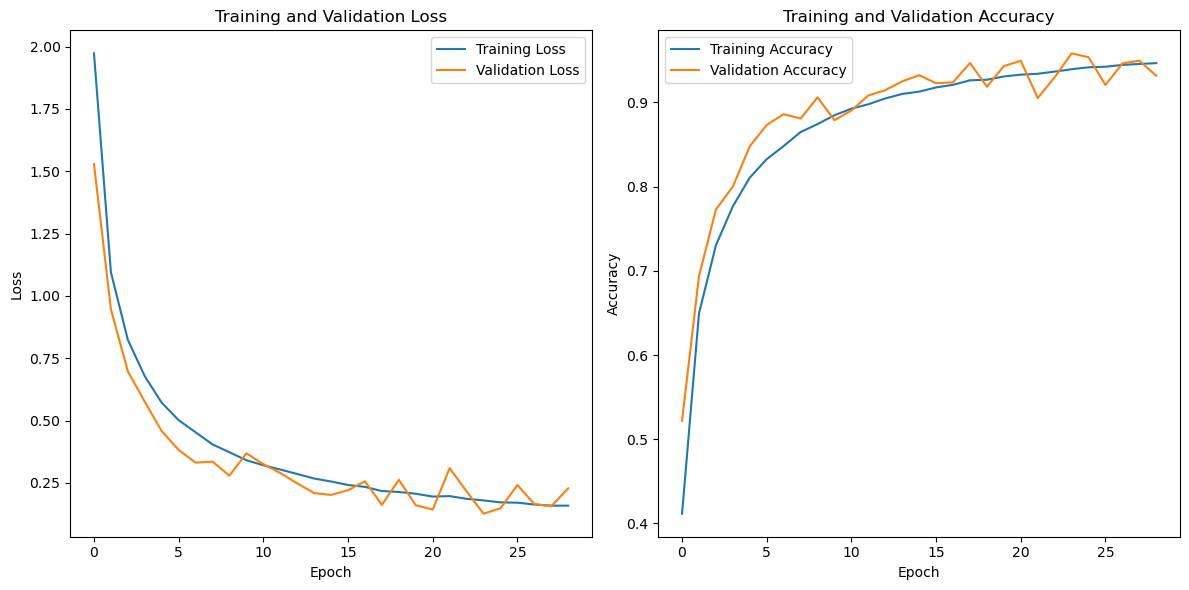

In [10]:
# create a figure with two subplots

plt.figure(figsize = (12, 6))

# loss plot

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# accuracy plot

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# display the plot

plt.tight_layout()
plt.show()

In [11]:
imgs_dir = '/home/aditya/ADITYA/SIGN LANGUAGE DETECTION/Sign-Language-Detection/DATA/asl_alphabet_test/asl_alphabet_test'
imgs = os.listdir(imgs_dir)

class_mapping = train_images.class_indices

def get_class_label(predictions, class_mapping):
    labels_mapping = {v: k for k, v in class_mapping.items()}
    predicted_labels = [labels_mapping[pred] for pred in predictions]
    return predicted_labels

def predict_image_class(model, img_path, class_mapping):
    img = cv2.imread(os.path.join(imgs_dir, img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.expand_dims(cv2.resize(img, (64, 64)), axis = 0)
    predictions = np.argmax(model.predict(img, verbose = 0), axis = 1)
    predicted_labels = get_class_label(predictions, class_mapping)
    return predicted_labels

for img in imgs:
    predicted_labels = predict_image_class(model, img, class_mapping)
    print(f'Predicted Labels {img} -----> {predicted_labels}')

Predicted Labels nothing_test.jpg -----> ['nothing']
Predicted Labels H_test.jpg -----> ['H']
Predicted Labels P_test.jpg -----> ['P']
Predicted Labels N_test.jpg -----> ['N']
Predicted Labels B_test.jpg -----> ['B']
Predicted Labels R_test.jpg -----> ['R']
Predicted Labels D_test.jpg -----> ['D']
Predicted Labels space_test.jpg -----> ['space']
Predicted Labels K_test.jpg -----> ['K']
Predicted Labels S_test.jpg -----> ['S']
Predicted Labels U_test.jpg -----> ['U']
Predicted Labels V_test.jpg -----> ['V']
Predicted Labels C_test.jpg -----> ['C']
Predicted Labels J_test.jpg -----> ['J']
Predicted Labels O_test.jpg -----> ['O']
Predicted Labels T_test.jpg -----> ['T']
Predicted Labels F_test.jpg -----> ['F']
Predicted Labels W_test.jpg -----> ['W']
Predicted Labels X_test.jpg -----> ['X']
Predicted Labels Z_test.jpg -----> ['Z']
Predicted Labels L_test.jpg -----> ['L']
Predicted Labels Y_test.jpg -----> ['Y']
Predicted Labels A_test.jpg -----> ['A']
Predicted Labels E_test.jpg -----> ['

In [13]:
model.save("model.h5")

In [16]:
# Function to preprocess frames
def preprocess_frame(frame):
    # Resize to match model input size
    resized_frame = cv2.resize(frame, (64, 64))
    # Convert to grayscale
    gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
    # Normalize pixel values
    normalized_frame = gray_frame / 255.0
    # Expand dimensions to match model input shape
    expanded_frame = np.expand_dims(normalized_frame, axis=0)
    expanded_frame = np.expand_dims(expanded_frame, axis=-1)
    return expanded_frame

# Function to predict letter from frame
def predict_letter(frame, model, class_mapping):
    preprocessed_frame = preprocess_frame(frame)
    prediction = np.argmax(model.predict(preprocessed_frame), axis=1)
    predicted_label = class_mapping[prediction[0]]
    return predicted_label

# Load your trained model and class mapping
# Load your trained Keras model here
# Load your class mapping dictionary here
model = load_model("model.h5")
# Assuming you have trained your model using train_images
class_mapping = train_images.class_indices
# Invert the dictionary to get class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Get predicted letter
    predicted_letter = predict_letter(frame, model, class_mapping)
    
    # Display predicted letter on frame
    cv2.putText(frame, predicted_letter, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Display the frame
    cv2.imshow('Sign Language Detection', frame)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()


[ WARN:0@3377.354] global cap_v4l.cpp:997 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@3377.355] global obsensor_uvc_stream_channel.cpp:159 getStreamChannelGroup Camera index out of range
